## Prepare libraries

In [1]:
#! pip3 install -U git+https://github.com/albu/albumentations
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'

In [2]:
# libraries
import numpy as np
import pandas as pd
import sys
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.metrics import fbeta_score, f1_score, accuracy_score

import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import time 
import tqdm
import random
from PIL import Image
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR
import torch.nn.utils.weight_norm as weightNorm
import torch.nn.init as init

import cv2
import json 
import gc

import albumentations as albu
from albumentations import pytorch as AT

import smp_local as smp  

import scipy.special

cudnn.benchmark = True

sigmoid = lambda x: scipy.special.expit(x)

In [3]:
SEED = 300
base_dir = '../input/'
def seed_everything(seed=SEED):
    random.seed(seed)
    os.environ['PYHTONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(SEED)

## Prepare data

In [4]:
data_folder = '../input/train/'
label_folder = '../input/labels/train/'
data_list = list(map(lambda x: x.replace('.png', ''), os.listdir(data_folder)))

In [5]:
tr, val = train_test_split(data_list, test_size=0.1, random_state=SEED)

In [6]:
data_tr = list(map(lambda x: data_folder+x+'.png', tr))
data_tr_gt = list(map(lambda x: label_folder+x+'.tiff', tr))

data_val = list(map(lambda x: data_folder+x+'.png', val))
data_val_gt = list(map(lambda x: label_folder+x+'.tiff', val))

In [7]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

## Model

In [8]:
class CellDataset(Dataset):
    
    def __init__(
            self, 
            images_list, 
            mask_list, 
            augmentation=None, 
            preprocessing=None,
    ):

        self.images_list = images_list
        self.mask_list = mask_list
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_list[i])        
        mask = 1.0 - cv2.imread(self.mask_list[i], 0)/255.
        mask = mask[:,:,np.newaxis]
                
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
            
        return image, mask
        
    def __len__(self):
        return len(self.images_list)

    
    
class CellDatasetInference(Dataset):
    
    def __init__(
            self, 
            images_list, 
            augmentation=None, 
            preprocessing=None,
    ):

        self.images_list = images_list
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_list[i]) 

        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image)
            image= sample['image']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image)
            image = sample['image']
            
        return image
        
    def __len__(self):
        return len(self.images_list)

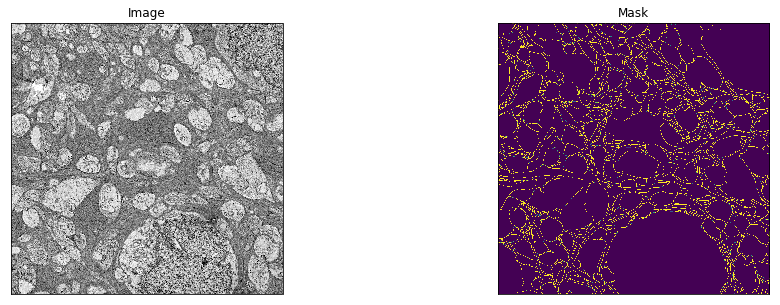

In [9]:
# Show train set

dataset = CellDataset(data_tr, data_tr_gt)

image, mask = dataset[4] # get some sample
visualize(
    image=image, 
    mask=mask.squeeze(),
)

In [10]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),
        
        albu.VerticalFlip(p=0.5),
        
#         albu.ShiftScaleRotate(scale_limit=0.25, rotate_limit=0, shift_limit=0.25, p=0.5),
        
#         albu.RandomResizedCrop(1024, 1024, scale=(0.4, 1.0), ratio=(0.75, 1.33),always_apply=True),
#         albu.RandomCrop(1024,1024,always_apply=True),
        
        albu.IAAAdditiveGaussianNoise(p=0.2),

        albu.OneOf(
            [
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
                albu.JpegCompression(quality_lower=20, quality_upper=90, p=1),
                albu.RandomContrast(p=1),
                #albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
            ],
            p=0.5,
        ),

    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    
    test_transform = [
        albu.PadIfNeeded(1024, 1024),
    ]
    return albu.Compose(test_transform)

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

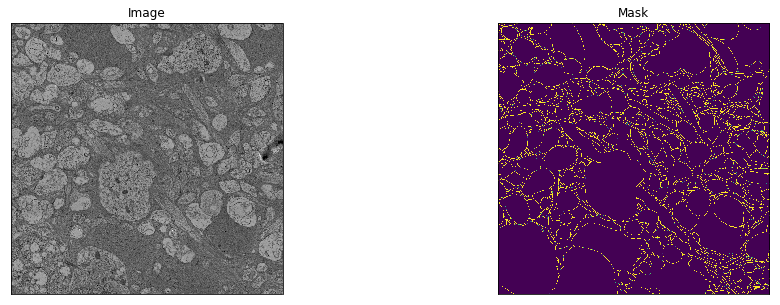

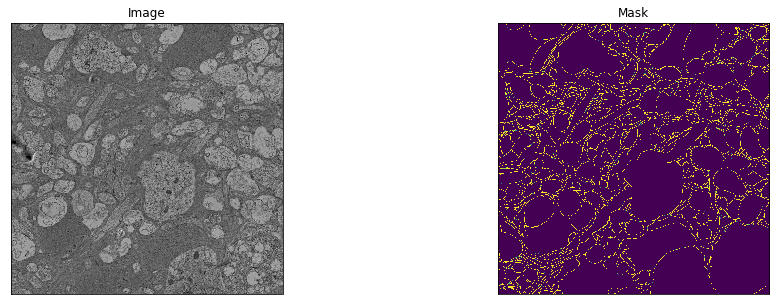

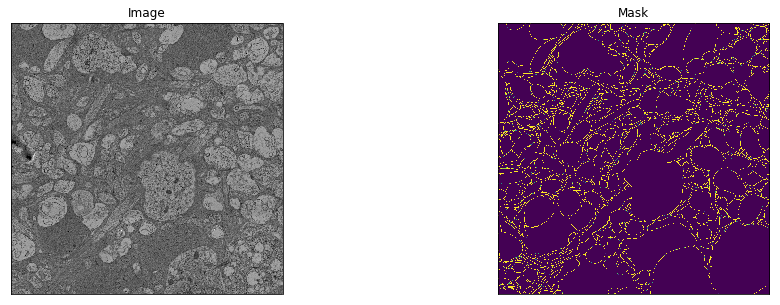

In [11]:
#### Visualize resulted augmented images and masks

augmented_dataset = CellDataset(data_tr, data_tr_gt, augmentation=get_training_augmentation())

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[25]
    visualize(image=image, mask=mask.squeeze())

In [12]:
class FocalLoss(nn.Module):
    __name__ = 'FocalLoss'
    def __init__(self, alpha=0.25, gamma=2, weight=None, ignore_index=None):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.weight = weight
        self.ignore_index = ignore_index
        self.bce_fn = nn.BCEWithLogitsLoss(weight=self.weight)

    def forward(self, preds, labels):
        if self.ignore_index is not None:
            mask = labels != self.ignore_index
            labels = labels[mask]
            preds = preds[mask]

        logpt = -self.bce_fn(preds, labels)
        pt = torch.exp(logpt)
        loss = -((1 - pt) ** self.gamma) * self.alpha * logpt
        return loss

In [13]:
def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    p = len(gt_sorted)
    gts = gt_sorted.sum()
    intersection = gts - gt_sorted.float().cumsum(0)
    union = gts + (1 - gt_sorted).float().cumsum(0)
    jaccard = 1 - intersection / union
    if p > 1:  # cover 1-pixel case
        jaccard[1:p] = jaccard[1:p] - jaccard[0:-1]
    return jaccard


def hinge(pred, label):
    signs = 2 * label - 1
    errors = 1 - pred * signs
    return errors


def lovasz_hinge_flat(logits, labels, ignore_index):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore_index: label to ignore
    """
    logits = logits.contiguous().view(-1)
    labels = labels.contiguous().view(-1)
    
    errors = hinge(logits, labels)
    errors_sorted, perm = torch.sort(errors, dim=0, descending=True)
    perm = perm.data
    gt_sorted = labels[perm]
    grad = lovasz_grad(gt_sorted)
    loss = torch.dot(F.elu(errors_sorted) + 1, grad)
    return loss


class LovaszLoss(nn.Module):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore_index: label to ignore
    """
    __name__ = 'LovaszLoss'
    def __init__(self, ignore_index=None):
        super().__init__()
        self.ignore_index = ignore_index

    def forward(self, logits, labels):
        return lovasz_hinge_flat(logits, labels, self.ignore_index)

In [14]:
class SoftDiceLoss_binary(nn.Module):
    __name__ = 'SoftDiceLoss'
    def __init__(self):
        super(SoftDiceLoss_binary, self).__init__()

    def forward(self, input, target):
        smooth = 0.01
        batch_size = input.size(0)
        input = F.sigmoid(input).view(batch_size, -1)
        # print(target.shape)
        # print(target.view(-1))
        target = target.clone().view(batch_size, -1)

        inter = torch.sum(input * target, 1) + smooth
        union = torch.sum(input * input, 1) + torch.sum(target * target, 1) + smooth

        score = torch.sum(2.0 * inter / union) / float(batch_size)
        score = 1.0 - torch.clamp(score, 0.0, 1.0 - 1e-7)

        return score

In [15]:
class WeightedBCELoss(nn.Module):
    __name__ = 'WeightedBCELoss'
    def __init__(self, weight):
        super(WeightedBCELoss, self).__init__()
        self.weight = weight

    def forward(self, input, target):
        c = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(self.weight))
        return c(input, target)


In [16]:
#ENCODER = 'resnext101_32x8d'
ENCODER = 'resnet34'
ENCODER_WEIGHTS = 'imagenet'
DEVICE = 'cuda'

#ACTIVATION = 'sigmoid'
ACTIVATION = None

In [17]:
# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=1, 
    activation=ACTIVATION,
)
model.cuda()
model = nn.DataParallel(model)
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [18]:
preprocessing_fn

functools.partial(<function preprocess_input at 0x7fc45cdbd7a0>, input_space='RGB', input_range=[0, 1], mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [19]:
model.train()

DataParallel(
  (module): Unet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): B

In [20]:
train_dataset = CellDataset(
    data_tr, 
    data_tr_gt, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
)

valid_dataset = CellDataset(
    data_val, 
    data_val_gt, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=8)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

/home/fangxi/miniconda3/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:1906: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  warnings.warn('Using lambda is incompatible with multiprocessing. '


## Training

In [21]:
import math

def CosineAnnealingWarmUpRestarts(epoch, T_0, T_warmup=0, gamma=1.,):
    stage = epoch//T_0
    max_lr = gamma**(stage)
    res = epoch  - stage*T_0
    if epoch < 0:
        return 1
    elif res <= T_warmup:
        return ((0.95/T_warmup)*res+0.05)*max_lr
    else:
        return (0.05*max_lr + 0.95*max_lr * (1 + math.cos(math.pi * (res-T_warmup)/(T_0-T_warmup))) / 2)

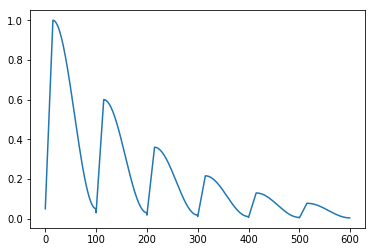

In [22]:
import matplotlib.pyplot as plt
lr = lambda x: CosineAnnealingWarmUpRestarts(x, 100, 15, 0.6)
plt.plot(list(range(600)),list(map(lr, range(600))))

In [23]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

#loss = smp.utils.losses.BCEDiceLoss(eps=1.)
#loss = SoftDiceLoss_binary()
#loss = FocalLoss()
loss = WeightedBCELoss(3)

metrics = [
    smp.utils.metrics.IoUMetric(eps=1.),
    smp.utils.metrics.FscoreMetric(eps=1.),
    smp.utils.metrics.PrecisionMetric(),
]

lr = 6e-3

optimizer = torch.optim.Adam([
    {'params': model.module.decoder.parameters(), 'lr': lr, 'weight_decay': 0.01}, 
    {'params': model.module.encoder.parameters(), 'lr': lr*0.01}
])

AttributeError: module 'smp_local.utils.metrics' has no attribute 'PrecisionMetric'

In [28]:
smp.utils.metrics.PrecisionMetric

AttributeError: module 'smp_local.utils.metrics' has no attribute 'PrecisionMetric'

In [ ]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
    accumulation_steps = 6,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [ ]:
# train model 

max_score = 0

for i in range(0, 1000):
    
    lr_rate = CosineAnnealingWarmUpRestarts(i, T_0=100, T_warmup=15, gamma=0.9,)
    
    optimizer.param_groups[0]['lr'] = lr_rate * lr
    optimizer.param_groups[1]['lr'] = lr_rate * lr * 0.01
        
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    seed_everything(seed=SEED+i)
    
    if i%5 == 0:
        valid_logs = valid_epoch.run(valid_loader)
    
        # do something (save model, change lr, etc.)
        if max_score < valid_logs['precision']:
            max_score = valid_logs['precision']
            torch.save(model.module, './best_model.pth')
            print('Model saved!')
            
torch.save(model.module, './end_model.pth')

## Testing

In [ ]:
# load best saved checkpoint
best_model = torch.load('./best_model.pth')

In [ ]:
# create test dataset
test_dataset = CellDataset(
    data_val, 
    data_val_gt, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
)

test_dataloader = DataLoader(test_dataset)

In [ ]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

# best :BCEDice Loss 0.535

## Visualize result

In [ ]:
# test dataset without transformations for image visualization
test_dataset_vis = CellDataset(
    data_val, data_val_gt, 
)

In [ ]:
for i in range(5):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = pr_mask.squeeze().cpu().numpy()
        
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=sigmoid(pr_mask)
    )

In [ ]:
visualize(mask = sigmoid(pr_mask)>0.5)

In [ ]:
# 遍历阈值求分数

In [ ]:
a = gt_mask.reshape(1024*1024)
b = (sigmoid(pr_mask)>0.5).reshape(1024*1024)
accuracy_score(np.array(a,dtype=int), b)

## Inference

In [ ]:
# create inference dataset

data_inference_dir = '../input/val/'
data_inference_names = os.listdir(data_inference_dir)

data_inference = list(map(lambda x: data_inference_dir+x, data_inference_names))

inference_dataset = CellDatasetInference(
    data_inference, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
)

In [ ]:
for i in range(len(data_inference_names)):
    image = inference_dataset[i]
    name = data_inference_names[i]
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = pr_mask.squeeze().cpu().numpy()
        
    save = sigmoid(pr_mask)>0.5
    save = (1 - save)*255
    cv2.imwrite('result/'+name.replace('.png','.tiff'), save)